In [128]:
import math
import napari
import numpy as np
import tifffile as tf

from PyQt5.QtWidgets import QFileDialog
from matplotlib import pyplot as plt

Create a Napari Viewer instance and prompt user to select image file.

In [129]:
# QFileDialog seems to require a running PyQt app
viewer = napari.Viewer()

# prompt user to select tiff file for analysis
fname = QFileDialog.getOpenFileName(None, 'Open file', 'C:\\Users\\lukas',"Image files (*.tif)")[0]

Confirm that the raw imaging data is either unsigned 8- or 16-bit. Convert data to floating point.

In [130]:
img = tf.imread(fname)

# confirm valid image data type
if img.dtype not in (np.uint8, np.uint16):
    print(f"Image has unsuported data type {img.dtype}")
    raise TypeError

# convert to floating point
img = img.astype(np.float64)

# subtract top and bottom planes for later comparison
subtraction = img[0] - img[-1]

err_baseline = np.sqrt(np.sum(np.square(subtraction)))

Shift the top and bottom images relative to one another and compare error values. Find the row shift that produces the lowest error.

In [131]:
# shift images some fraction of original shape
shift_y = math.trunc(img.shape[1]/20)

err_y_down = np.empty((shift_y), dtype=np.float64)
err_y_up = np.empty((shift_y), dtype=np.float64)

err_y_down[0] = err_baseline
err_y_up[0] = err_baseline

# y-axis shift-down
for r in range(1, shift_y):
    # subtract pixel values from first and last slices
    sub = img[0][:-r] - img[-1][r:]
    err_y_down[r] = np.sqrt(np.sum(np.square(sub)))

# y-axis shift-up
for r in range(1, shift_y):
    # subtract pixel values from first and last slices
    sub = img[0][r:] - img[-1][:-r]
    err_y_up[r] = np.sqrt(np.sum(np.square(sub)))

In [132]:
vertex_down = np.amin(err_y_down)
vertex_up = np.amin(err_y_up)

if vertex_down < vertex_up:
    err_factor_y = np.where(err_y_down == vertex_down)[0][0]
    correction_y = img[0][:-err_factor_y] - img[-1][err_factor_y:]
    print(f"Shift down by {err_factor_y} rows")
else:
    err_factor_y = np.where(err_y_up == vertex_up)[0][0]
    correction_y = img[0][err_factor_y:] - img[-1][:-err_factor_y]
    print(f"Shift up by {err_factor_y} rows")

Shift down by 18 rows


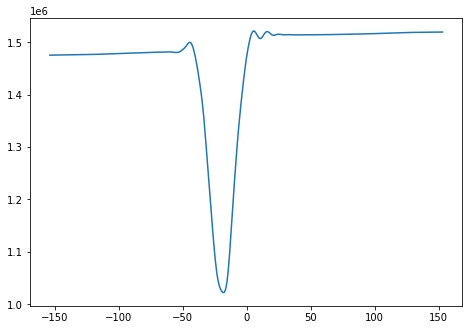

In [133]:
err_y = np.append(np.flip(err_y_down), err_y_up[1:])

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(np.linspace(-shift_y, shift_y-1, num=shift_y*2-1), err_y)
fig.savefig("error_y.jpg", bbox_inches="tight")

In [135]:
shift_x = math.trunc(img.shape[2]/20)

err_x_left = np.empty((shift_x), dtype=np.float64)
err_x_right = np.empty((shift_x), dtype=np.float64)

err_x_left[0] = err_baseline
err_x_right[0] = err_baseline

# x-axis shift-right
for c in range(1, shift_x):
    # subtract pixel values from first and last slices
    sub = img[0][:, c:] - img[-1][:, :-c]
    err_x_right[c] = np.sqrt(np.sum(np.square(sub)))

# x-axis shift-left
for c in range(1, shift_x):
    # subtract pixel values from first and last slices
    sub = img[0][:, :-c] - img[-1][:, c:]
    err_x_left[c] = np.sqrt(np.sum(np.square(sub)))

In [136]:
vertex_right = np.amin(err_x_right)
vertex_left = np.amin(err_x_left)

if vertex_right < vertex_left:
    err_factor_x = np.where(err_x_right == vertex_right)[0][0]
    correction_x = img[0][:, err_factor_x:] - img[-1][:, :-err_factor_x]
    print(f"Shift right by {err_factor_x} columns")
else:
    err_factor_x = np.where(err_x_left == vertex_left)[0][0]
    correction_x = img[0][:, :-err_factor_x] - img[-1][:, err_factor_x:]
    print(f"Shift right by {err_factor_x} columns")

Shift right by 3 columns


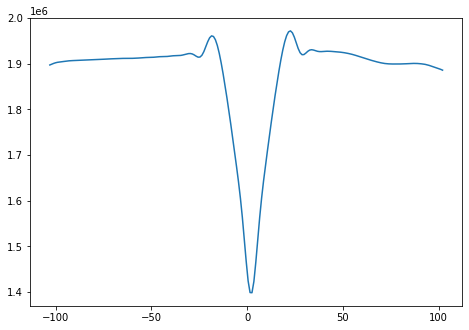

In [138]:
err_x = np.append(np.flip(err_x_right), err_x_left[1:])

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(np.linspace(-shift_x, shift_x-1, num=shift_x*2-1), err_x)
fig.savefig("error_x.jpg", bbox_inches="tight")

In [139]:
viewer.dims.axis_labels = ("z", "y", "x")

viewer.add_image(img)
viewer.add_image(subtraction)
viewer.add_image(correction_y)
viewer.add_image(correction_x)

<Image layer 'correction_x' at 0x13b99a6b460>